In [41]:
import pandas as pd

df = pd.read_csv("../data/adobe_style_campaign_data.csv")
df.head()

,date,campaign_id,campaign_name,channel,region,device,impressions,clicks,visits,unique_visitors,...,step2_product_view,step3_add_to_cart,step4_checkout_start,step5_purchase,conversions,revenue,spend,roas,anomaly_flag,anomaly_type
0,2025-01-01,C01,Campaign 1,Search,US,iOS,24544,1555,1448,1175,...,732,503,418,281,281,10729.281579,951.329822,11.278193,0,NaN
1,2025-01-01,C01,Campaign 1,Search,UK,iOS,15333,733,749,620,...,550,208,146,117,117,2883.469829,976.961640,2.951467,0,NaN
2,2025-01-01,C01,Campaign 1,Search,EU,iOS,16248,242,222,207,...,113,75,45,37,37,1893.330982,286.555984,6.607194,0,NaN
3,2025-01-01,C01,Campaign 1,Search,APAC,iOS,14828,378,411,402,...,238,150,96,67,67,4976.063757,203.957907,24.397504,0,NaN
4,2025-01-01,C01,Campaign 1,Search,US,Android,20977,356,334,267,...,244,80,51,32,32,3401.930963,484.020026,7.028492,0,NaN


In [206]:
df['anomaly_type'].value_counts()

anomaly_type
conversion_drop            6
high_bounce_load           5
roas_spike_tracking_bug    3
Name: count, dtype: int64

In [334]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [330]:
# anomaly distribution

query = """

SELECT
    campaign_name
    , region
    , device
    , channel 
    , anomaly_flag
    , anomaly_type
FROM
    df
WHERE
    anomaly_flag = 1

"""
summary_stat = pysqldf(query)
summary_stat


,campaign_name,region,device,channel,anomaly_flag,anomaly_type
0,Campaign 3,UK,iOS,Social,1,high_bounce_load
1,Campaign 3,UK,iOS,Social,1,high_bounce_load
2,Campaign 3,UK,iOS,Social,1,high_bounce_load
3,Campaign 3,UK,iOS,Social,1,high_bounce_load
4,Campaign 3,UK,iOS,Social,1,high_bounce_load
5,Campaign 7,EU,Desktop,Display,1,roas_spike_tracking_bug
6,Campaign 7,EU,Desktop,Display,1,roas_spike_tracking_bug
7,Campaign 7,EU,Desktop,Display,1,roas_spike_tracking_bug
8,Campaign 1,US,iOS,Search,1,conversion_drop
9,Campaign 1,US,iOS,Search,1,conversion_drop


In [331]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   21600 non-null  object 
 1   campaign_id            21600 non-null  object 
 2   campaign_name          21600 non-null  object 
 3   channel                21600 non-null  object 
 4   region                 21600 non-null  object 
 5   device                 21600 non-null  object 
 6   impressions            21600 non-null  int64  
 7   clicks                 21600 non-null  int64  
 8   visits                 21600 non-null  int64  
 9   unique_visitors        21600 non-null  int64  
 10  pageviews              21600 non-null  int64  
 11  bounce_rate            21600 non-null  float64
 12  avg_page_load_time_ms  21600 non-null  float64
 13  step1_landing          21600 non-null  int64  
 14  step2_product_view     21600 non-null  int64  
 15  st

In [332]:
df.groupby(['channel', 'region', 'device']).size()

channel  region  device 
Display  APAC    Android    600
                 Desktop    600
                 iOS        600
         EU      Android    600
                 Desktop    600
                 iOS        600
         UK      Android    600
                 Desktop    600
                 iOS        600
         US      Android    600
                 Desktop    600
                 iOS        600
Search   APAC    Android    600
                 Desktop    600
                 iOS        600
         EU      Android    600
                 Desktop    600
                 iOS        600
         UK      Android    600
                 Desktop    600
                 iOS        600
         US      Android    600
                 Desktop    600
                 iOS        600
Social   APAC    Android    600
                 Desktop    600
                 iOS        600
         EU      Android    600
                 Desktop    600
                 iOS        600
         UK    

In [333]:
!pip install pandasql

In [446]:
query = """

SELECT
    date
    , region
    , device
    , SUM(unique_visitors) AS total_unique_visitors 
FROM 
    df
GROUP BY
    1,2,3
ORDER BY
    1,2,3
    
"""
daily_visitors = pysqldf(query)
daily_visitors.head()

,date,region,device,total_unique_visitors
0,2025-01-01,APAC,Android,15329
1,2025-01-01,APAC,Desktop,14121
2,2025-01-01,APAC,iOS,19337
3,2025-01-01,EU,Android,19207
4,2025-01-01,EU,Desktop,16335


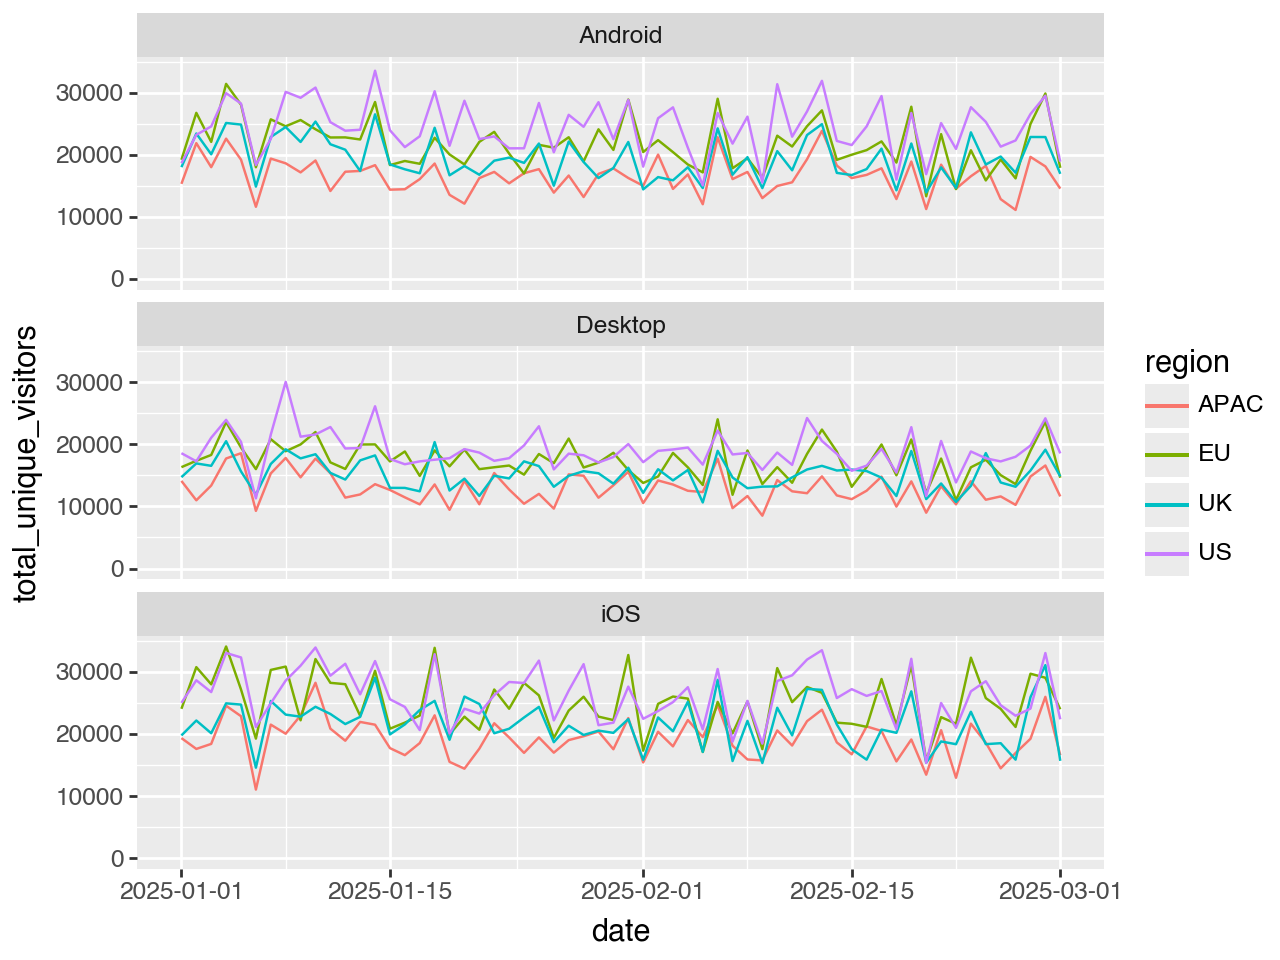

In [461]:
daily_visitors['date'] = pd.to_datetime(daily_visitors['date'])
ggplot(daily_visitors, aes(x= 'date', y='total_unique_visitors', group= 'region', color = 'region'))+geom_line()+scale_y_continuous(limits = (0,None))+facet_wrap('~device', ncol=1)

In [462]:
# summary stat 

query = """

SELECT
    campaign_name
    , region
    , device
    , channel
    , SUM(impressions) AS impressions
    , SUM(clicks) AS clicks
    , 1.0*SUM(conversions) AS conversions
    , 1.0*SUM(clicks)/SUM(impressions) AS ctr
    , 1.0*SUM(conversions)/SUM(clicks) AS cvr
    , 1.0*SUM(conversions)/SUM(impressions) AS vcr   
FROM
    df
GROUP BY
    1,2,3,4
ORDER BY
    cvr DESC

"""
summary_stat = pysqldf(query)
summary_stat.head()


,campaign_name,region,device,channel,impressions,clicks,conversions,ctr,cvr,vcr
0,Campaign 3,UK,Desktop,Social,742772,33621,6774.0,0.045264,0.201481,0.009120
1,Campaign 5,EU,Android,Display,754993,32679,6519.0,0.043284,0.199486,0.008635
2,Campaign 6,UK,Desktop,Search,935414,46728,9308.0,0.049954,0.199195,0.009951
3,Campaign 8,UK,Desktop,Social,803598,33282,6545.0,0.041416,0.196653,0.008145
4,Campaign 2,APAC,iOS,Search,1151566,51528,10061.0,0.044746,0.195253,0.008737


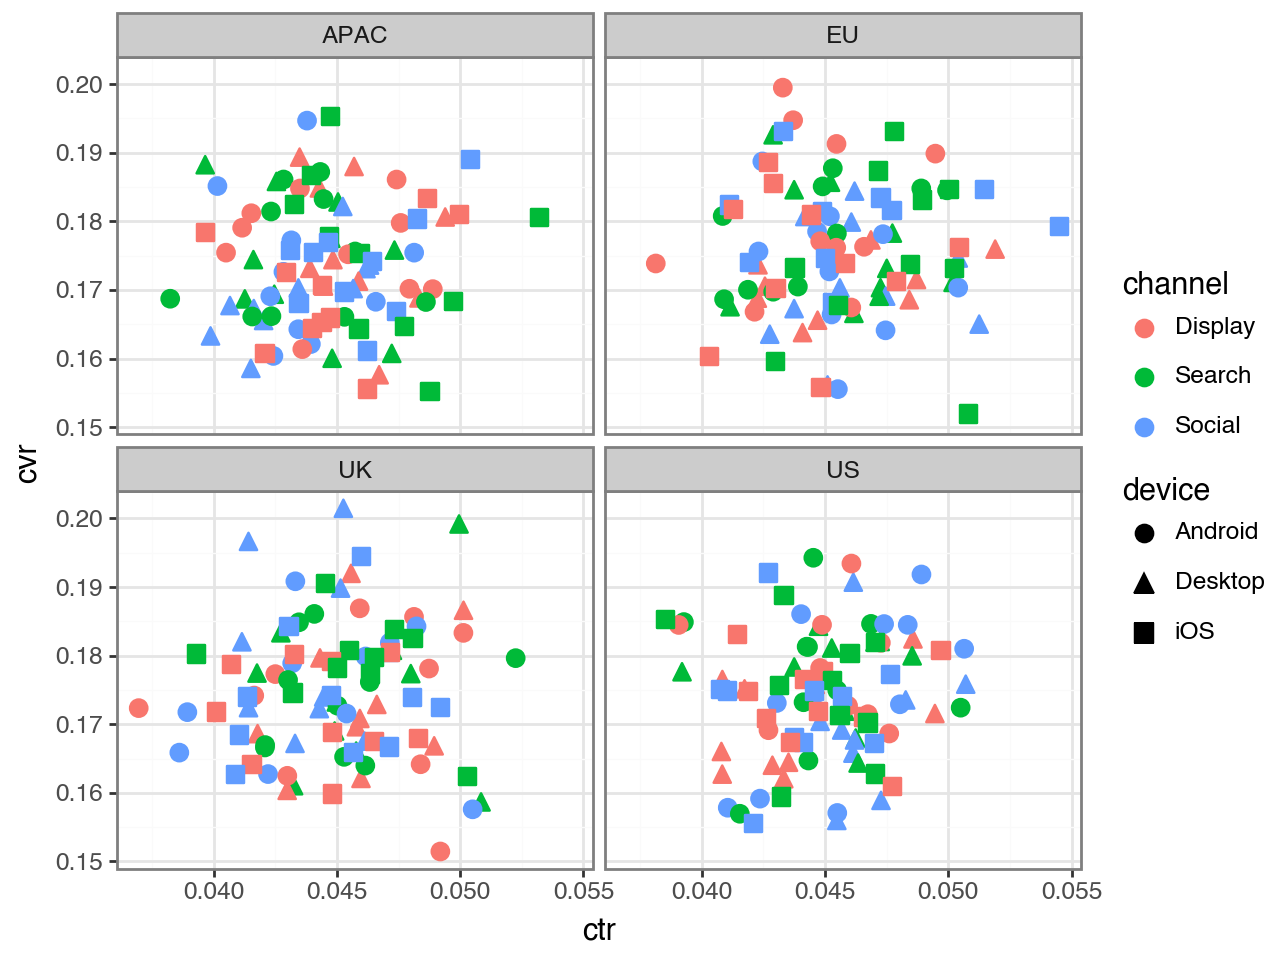

In [463]:
from plotnine import ggplot, aes, geom_point, facet_wrap, theme_bw

(
    ggplot(summary_stat, aes(x='ctr', y='cvr', color='channel', shape='device'))
    + geom_point(size=3)
    + facet_wrap('~region')
    + theme_bw()
)


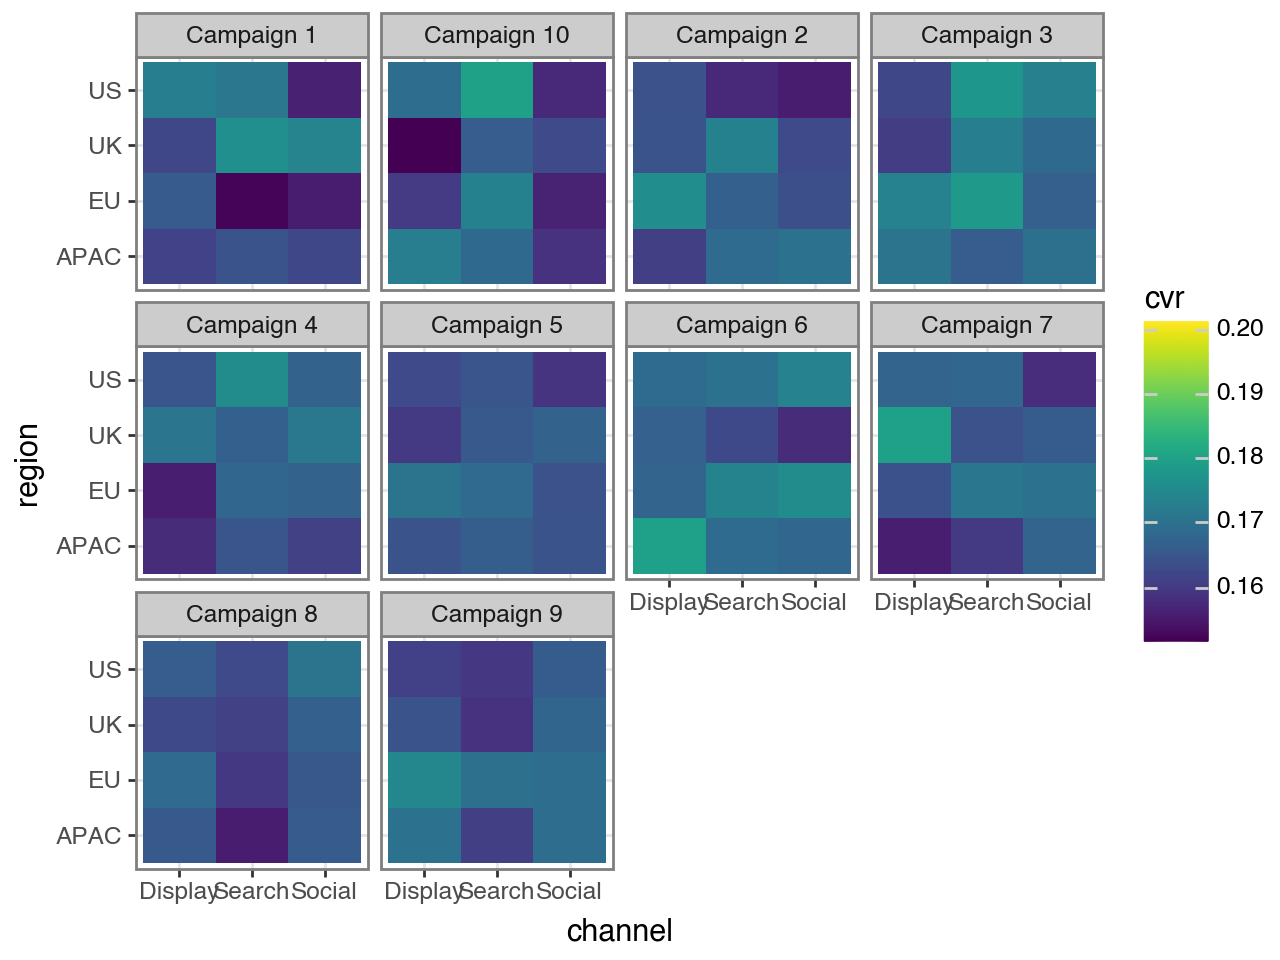

In [464]:
from plotnine import geom_tile

(
    ggplot(summary_stat, aes(x='channel', y='region', fill='cvr'))
    + geom_tile()
    + theme_bw()
    + facet_wrap('~campaign_name')

)

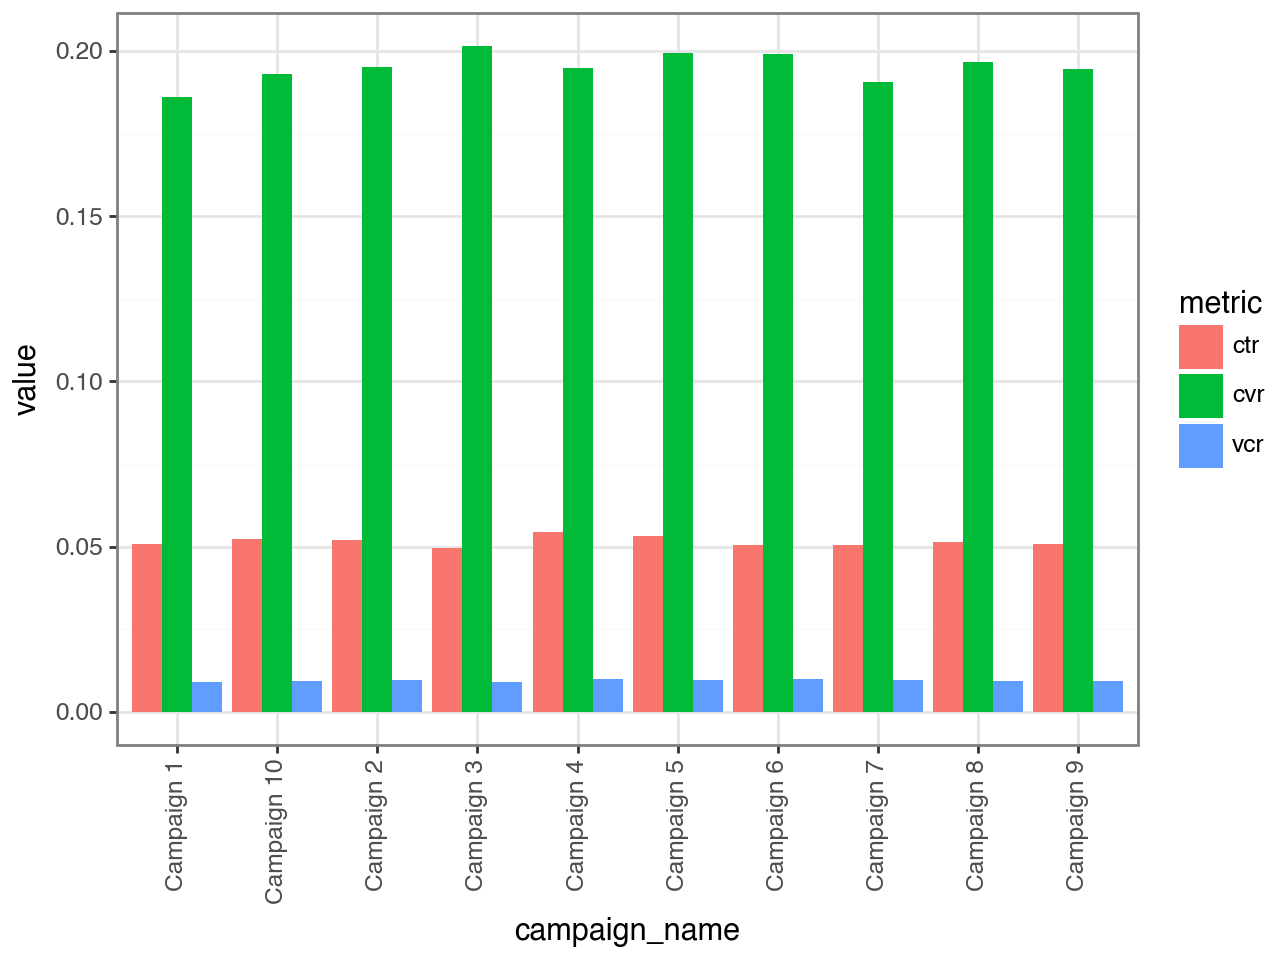

In [465]:
df_long = summary_stat.melt(
    id_vars=['campaign_name'],
    value_vars=['ctr','cvr','vcr'],
    var_name='metric',
    value_name='value'
)

(
    ggplot(df_long, aes(x='campaign_name', y='value', fill='metric'))
    + geom_col(position='dodge')
    + theme_bw()+theme(axis_text_x=element_text(rotation=90))
)


In [466]:
# user journey

query = """

SELECT
    campaign_name
    , SUM(step1_landing) AS step1_landing
    , SUM(step2_product_view) AS step2_product_view
    , SUM(step3_add_to_cart) AS step3_add_to_cart
    , SUM(step4_checkout_start) AS step4_checkout_start
    , SUM(step5_purchase) AS step5_purchase
    , 1.0*SUM(step2_product_view)/SUM(step1_landing) AS step1_landing_to_view
    , 1.0*SUM(step3_add_to_cart)/SUM(step2_product_view) AS step2_view_to_add
    , 1.0*SUM(step4_checkout_start)/SUM(step3_add_to_cart) AS step3_add_to_checkout
    , 1.0*SUM(step5_purchase)/SUM(step4_checkout_start) AS step4_checkout_to_purchase
FROM 
    df
GROUP BY
    1
ORDER BY
    1

"""

checkout_journey = pysqldf(query)
checkout_journey.head()


,campaign_name,step1_landing,step2_product_view,step3_add_to_cart,step4_checkout_start,step5_purchase,step1_landing_to_view,step2_view_to_add,step3_add_to_checkout,step4_checkout_to_purchase
0,Campaign 1,1548584,1002506,495834,344774,266259,0.647369,0.494595,0.695342,0.772271
1,Campaign 10,1768951,1146349,572798,402392,311139,0.648039,0.499672,0.702502,0.773224
2,Campaign 2,1574601,1019944,509995,357840,275353,0.647748,0.500023,0.701654,0.769486
3,Campaign 3,1567483,1023798,513059,361595,278841,0.653148,0.501133,0.704782,0.771142
4,Campaign 4,1502271,970346,484262,338209,261574,0.645919,0.499061,0.698401,0.773409


In [467]:
checkout_journey_reshaped = pd.melt(
    checkout_journey, 
    id_vars = 'campaign_name', 
    value_vars =['step1_landing','step2_product_view','step3_add_to_cart', 'step4_checkout_start', 'step5_purchase'], 
    var_name = 'funnel_step'
)

In [468]:
!pip install plotnine

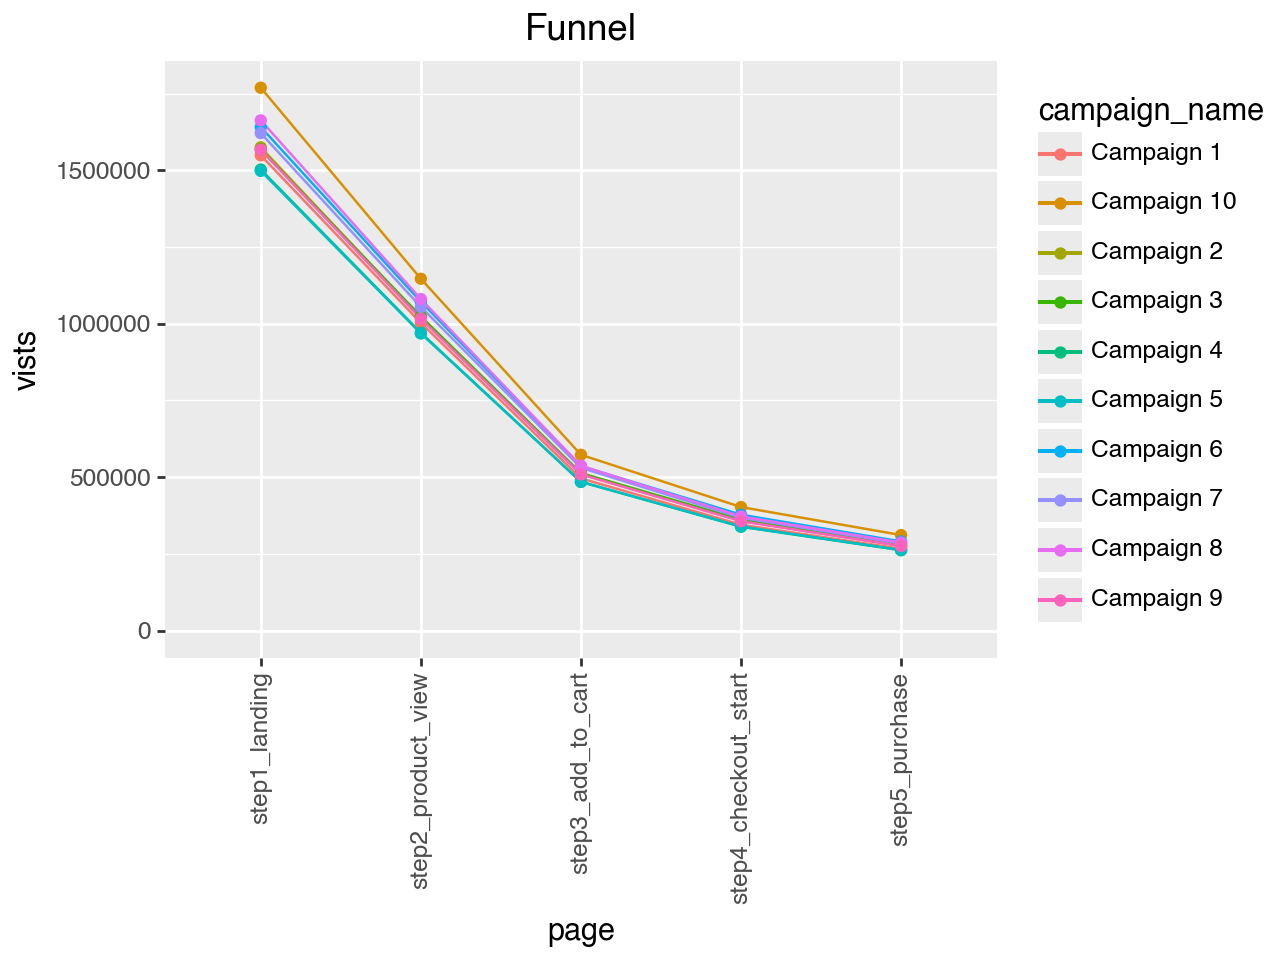

In [469]:
from plotnine import ggplot, aes, geom_point, geom_line, theme_bw, theme, element_text, labs, scale_y_continuous
(ggplot(checkout_journey_reshaped, aes(x = 'funnel_step', y = 'value', group = 'campaign_name', colour = 'campaign_name'))
+geom_line()+geom_point()+theme(axis_text_x=element_text(rotation=90))+labs(y='vists', x='page', title ='Funnel')
+scale_y_continuous(limits = (0,None)))

In [470]:
df.head()

,date,campaign_id,campaign_name,channel,region,device,impressions,clicks,visits,unique_visitors,...,step2_product_view,step3_add_to_cart,step4_checkout_start,step5_purchase,conversions,revenue,spend,roas,anomaly_flag,anomaly_type
0,2025-01-01,C01,Campaign 1,Search,US,iOS,24544,1555,1448,1175,...,732,503,418,281,281,10729.281579,951.329822,11.278193,0,NaN
1,2025-01-01,C01,Campaign 1,Search,UK,iOS,15333,733,749,620,...,550,208,146,117,117,2883.469829,976.961640,2.951467,0,NaN
2,2025-01-01,C01,Campaign 1,Search,EU,iOS,16248,242,222,207,...,113,75,45,37,37,1893.330982,286.555984,6.607194,0,NaN
3,2025-01-01,C01,Campaign 1,Search,APAC,iOS,14828,378,411,402,...,238,150,96,67,67,4976.063757,203.957907,24.397504,0,NaN
4,2025-01-01,C01,Campaign 1,Search,US,Android,20977,356,334,267,...,244,80,51,32,32,3401.930963,484.020026,7.028492,0,NaN


In [471]:
query = """

SELECT
    campaign_name
    , region
    , channel
    , SUM(revenue) AS revenue_total
    , SUM(spend) AS spend_total
    , 1.0*SUM(revenue)/SUM(spend) AS roas
FROM 
    df
GROUP BY
    1,2,3
ORDER BY
    roas DESC

"""
roas = pysqldf(query)
roas.head()

,campaign_name,region,channel,revenue_total,spend_total,roas
0,Campaign 3,US,Search,2.513257e+06,193961.398541,12.957513
1,Campaign 5,US,Display,1.477288e+06,121706.048610,12.138165
2,Campaign 9,APAC,Search,1.710501e+06,141198.971989,12.114117
3,Campaign 4,US,Search,2.236981e+06,185599.271412,12.052747
4,Campaign 2,EU,Display,1.445668e+06,120057.400149,12.041473


In [472]:
# sanity check 

query = """

SELECT
    campaign_name
    , 1.0*SUM(roas*spend)/SUM(spend) AS roas_spend_weighted
FROM 
    df
GROUP BY
    1
ORDER BY
    2 DESC

"""
roas_ = pysqldf(query)
roas_.head()

,campaign_name,roas_spend_weighted
0,Campaign 3,11.023328
1,Campaign 5,10.918698
2,Campaign 9,10.889224
3,Campaign 4,10.753471
4,Campaign 2,10.730148


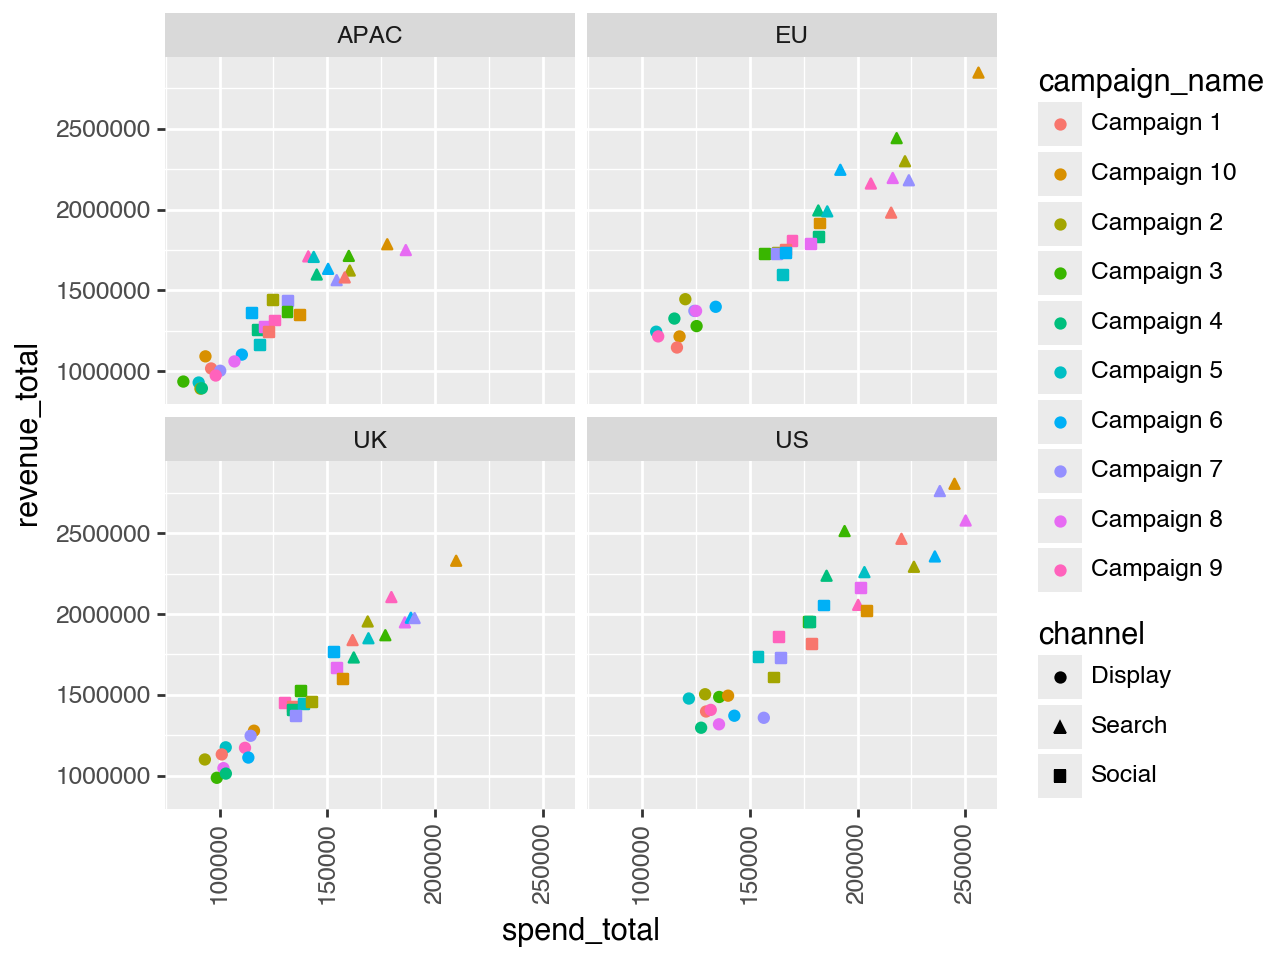

In [473]:
from plotnine import geom_point
ggplot(roas, aes(x= 'spend_total', y= 'revenue_total', group = 'campaign_name', color = 'campaign_name', shape = 'channel'))+geom_point()+facet_wrap('~region')+theme(axis_text_x=element_text(rotation=90))